In [1]:
import pandas as pd
import re
import nltk
import xgboost
import re
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn import metrics

In [3]:
from OpenDutchWordnet import Wn_grid_parser

instance = Wn_grid_parser(path_wn_grid_lmf='odwn_orbn_gwg-LMF_1.3.xml.gz')

def get_hypernyms (synset_id, hypers):
    print('Synset', synset_id)
    synset = instance.synsets_find_synset(synset_id)
    if synset:
        hypernyms = synset.get_relations("has_hyperonym")
        if hypernyms:
            for h in hypernyms:
                if (h):
                    print('Target', h.get_target())
                    if not h.get_target() in hypers:
                        hypers.append(h.get_target())
                        get_hypernyms(h.get_target(), hypers)


le_el = instance.les_find_le("voelen-v-2")
synset_el = instance.synsets_find_synset(le_el.get_synset_id())
hypers = []
get_hypernyms(synset_el.get_id(), hypers)
new_hypers = []
for hyper in hypers:
    print(hyper)
    new_hypers.append(hyper)
    for le in instance.les_all_les_of_one_synset(hyper):
        print(le.get_lemma())        

Synset eng-30-01771535-v
Target eng-30-02110552-v
Synset eng-30-02110552-v
Target eng-30-02110220-v
Synset eng-30-02110220-v
Target eng-30-02108377-v
Synset eng-30-02108377-v
Target eng-30-00109660-v
Synset eng-30-00109660-v
eng-30-02110552-v
beleven
ervaren
gevoelen
gewaarworden
ondervinden
ontmoeten
eng-30-02110220-v
beleven
doorleven
meemaken
eng-30-02108377-v
ondergaan
eng-30-00109660-v
zich omkleden
kenteren
keren
veranderen


In [27]:
for hyper in new_hypers:
#     le_el = instance.les_find_le(hyper)
#     synset_el = instance.synsets_find_synset(le_el.get_synset_id())
    hypers = []
    get_hypernyms(hyper, hypers)
    new_hypers = []
    for hyper in hypers:
        print(hyper)
        new_hypers.append(hyper)
        for le in instance.les_all_les_of_one_synset(hyper):
            print(le.get_lemma())

Synset eng-30-02110552-v
Target eng-30-02110220-v
Synset eng-30-02110220-v
Target eng-30-02108377-v
Synset eng-30-02108377-v
Target eng-30-00109660-v
Synset eng-30-00109660-v
eng-30-02110220-v
beleven
doorleven
meemaken
eng-30-02108377-v
ondergaan
eng-30-00109660-v
zich omkleden
kenteren
keren
veranderen
Synset eng-30-02110220-v
Target eng-30-02108377-v
Synset eng-30-02108377-v
Target eng-30-00109660-v
Synset eng-30-00109660-v
eng-30-02108377-v
ondergaan
eng-30-00109660-v
zich omkleden
kenteren
keren
veranderen
Synset eng-30-02108377-v
Target eng-30-00109660-v
Synset eng-30-00109660-v
eng-30-00109660-v
zich omkleden
kenteren
keren
veranderen
Synset eng-30-00109660-v


In [10]:
# df = pd.read_csv('preprocessed_data/fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb.csv', sep='\t')

df_test = pd.read_csv('experience_test/Fb_random_sample_500_annotated_discussed.tsv', sep='\t')
test_instances = df_test['object_id'].tolist()

df = pd.read_csv('preprocessed_data/data_subsets/high_sent_subjFB_NOS_NU_Telegraaf_NRC_all_endFeb.csv', sep='\t')
df = df[~df.object_id.isin(test_instances)]

In [11]:
def clean_text(text):
    no_urls = re.sub(r"http\S+", "", text)
    punctuations = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~’”“'
    text_clean = no_urls.translate(str.maketrans('', '', punctuations)).lower()
    return text_clean

df['clean_text'] = df['clean_text'].apply(lambda x: clean_text(x))
df_test['clean_text'] = df_test['message'].apply(lambda x: clean_text(x))

In [12]:
removes = ["ik", "hij", "wij", "zij", "mijn", "vader", "moeder", "ouders", "schoonvader", "schoonmoeder", "kind", "man", "vrouw", "zoon", "dochter", "broer", "zus"
           "opa", "oma", "neef", "nicht", "tante", "oom", "heb", "gehad", "hebben", "heeft", "voelt", "voelen", "gevoeld", "voelde", "voelden",
          "beleven", "beleefd", "beleeft", "beleefde", "beleefden" "ondervind", "ondervond", "ondervonden", "ondervinden",
          "doorleven", "doorleefde", "doorgeleefd", "meemaken", "maakte mee", "maak mee", "meegemaakt", "maakten mee", "ontmoeten", "ontmoette", "ontmoet"]

match = "heb .* gehad|heeft .* gehad |hebben .* gehad | mijn vader | mijn moeder | mijn ouders | mijn schoonvader | mijn schoonmoeder | mijn kind | mijn vrouw | mijn man | mijn zoon | mijn dochter | mijn broer | mijn zus | mijn opa | mijn oma | mijn neef | mijn nicht | mijn tante | mijn oom | voel*| beleef* | belev* | ervar* | ondervind* | ondervond* | doorleef* | doorlev* | meemak*"

# voel*| beleef* | belev* | ervar* | ondervind* | ondervond* | doorleef* | doorlev* | meemak*
# df['labels'] = df['clean_text'].apply(lambda x: 1 if any(y in x for y in matches) else 0)

df['labels'] = df['clean_text'].apply(lambda x: 1 if re.search(match, x) else 0)

# df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in removes]))

# df['clean_text'] = df['clean_text'].apply(lambda x: remove_match(["heb .* gehad"], x) if re.search(match, x) else x)
# df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([word for word in bigrams(x) if word not in matches]))
df_test['labels'].replace({"y": 1, "n": 0}, inplace=True)

In [43]:
# df[['text', 'labels']].to_csv('distant_labeled_high_sent_fb', sep='\t')

In [13]:
df_1 = df[df['labels'] == 1]
df_0 = df[df['labels'] == 0]
df_0_new = df_0.sample(len(df_1)+100, random_state=42)
df_new = pd.concat([df_1, df_0_new])

print('Amount of experiences:', len(df_1))
print('Amount of not-experiences', len(df_0_new))
print('Resampled number:', len(df_new))

Amount of experiences: 237
Amount of not-experiences 337
Resampled number: 574


In [14]:
corpus = df_new['clean_text'].tolist()
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(corpus)
y_train = df_new['labels']
X_test = tfidf.transform(df_test['clean_text'])
y_test = df_test['labels']

In [15]:
len(df_test[df_test['labels'] == 0])

451

In [16]:
def create_cm(true_labels, predicted_labels):
    """ Function to create confusion matrix of a classifier """
    cm = metrics.confusion_matrix(true_labels, predicted_labels)
        
    fig, ax = plot_confusion_matrix(conf_mat=cm,
                                    colorbar=False,
                                    show_absolute=False,
                                    show_normed=True,
                                    class_names=['non-exp','exp'])
    fig.set_size_inches(18.5, 10.5)
#     plt.savefig(name)

In [17]:
# BASELINE
print(classification_report(df_test['labels'], np.zeros(len(df_test['labels']))))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       451
           1       0.00      0.00      0.00        49

    accuracy                           0.90       500
   macro avg       0.45      0.50      0.47       500
weighted avg       0.81      0.90      0.86       500



C:\Users\jmich\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.95      0.94      0.94       451
           1       0.48      0.55      0.51        49

    accuracy                           0.90       500
   macro avg       0.72      0.74      0.73       500
weighted avg       0.90      0.90      0.90       500

0.7433594280284176


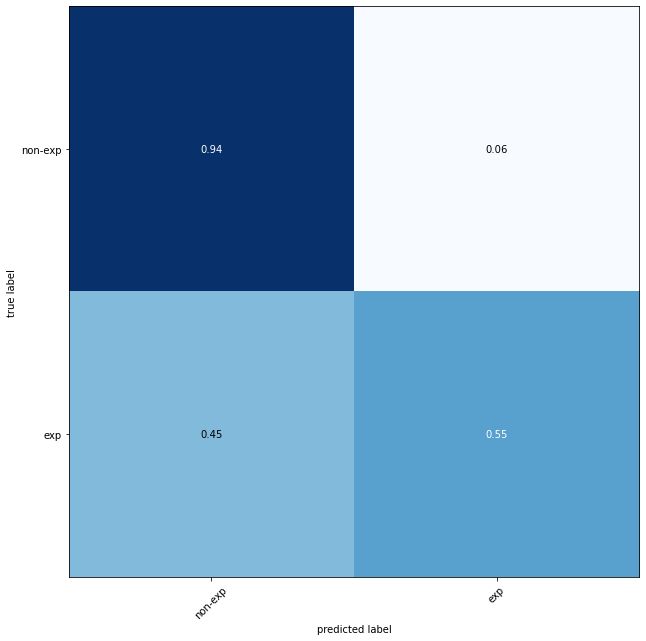

In [18]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


print(roc_auc_score(y_test, y_pred))
create_cm(y_test, y_pred)

In [19]:
y_prob = clf.predict_proba(X_test)[:,1]

In [20]:
df[['text', 'labels', 'pred_labels_LR', 'pred_proba_labels_LR']]

KeyError: "['pred_labels_LR', 'pred_proba_labels_LR'] not in index"

In [21]:
df['pred_proba_labels_LR'] = pd.Series(y_prob)
df['pred_labels_LR'] = pd.Series(y_pred)
df[['text', 'labels', 'pred_labels_LR', 'pred_proba_labels_LR']].to_csv('Data workshop/TEST_distant_predicted_labels_high_sent_fb_LR_with features.tsv', sep='\t')

In [22]:
df_new = pd.read_csv('preprocessed_data/fb_preprocessed_FB_NOS_NU_Telegraaf_NRC_all_endFeb.csv', sep='\t')
df_new = df_new[~df_new.object_id.isin(df.object_id.tolist())]

df_new['labels'] = df_new['clean_text'].apply(lambda x: 1 if re.search(match, x) else 0)

df_new['clean_text'] = df_new['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in removes]))

X = tfidf.transform(df_new['clean_text'])

y_pred = clf.predict(X)
df_new['pred_labels_LR'] = pd.Series(clf.predict(X))

df_new[['object_id', 'text', 'pred_labels_LR']].to_csv('new_data/distant_predicted_labels_fb_LR_with features.tsv', sep='\t')

In [23]:
names = tfidf.get_feature_names()
# get importance
importance = clf.coef_[0]
# summarize feature importance
importances = []
for i,v in enumerate(importance):
#     print('Feature: %0s, Score: %.5f' % (names[i],v))
    importances.append((names[i],v))
sorted(importances, key=lambda tup: tup[1], reverse=True)

[('gehad', 2.799579759850343),
 ('mijn', 1.9578653773037713),
 ('ik', 1.4568951744885852),
 ('voelt', 1.192368105883593),
 ('heb', 1.1332279146397948),
 ('heeft', 1.0470760367359524),
 ('haar', 0.9924369933439963),
 ('voeding', 0.9640050669195439),
 ('voeren', 0.9606356209957203),
 ('gezonde', 0.9248391577105358),
 ('corona', 0.8829423316499776),
 ('en', 0.8521378521445553),
 ('al', 0.8454219748078817),
 ('griep', 0.8382457302773968),
 ('met', 0.8200910171171115),
 ('nooit', 0.8128687841625167),
 ('voelen', 0.7957709713734573),
 ('voedsel', 0.7711430279187306),
 ('mij', 0.7522461251270915),
 ('ook', 0.7383423262700136),
 ('zou', 0.7301077000503114),
 ('een', 0.7206508486510103),
 ('geen', 0.7019120885369259),
 ('dan', 0.6850247945330513),
 ('moeder', 0.6830695800139021),
 ('vader', 0.6612354025201101),
 ('moeten', 0.6409522383586149),
 ('zich', 0.6261298356623506),
 ('waarom', 0.616632004108691),
 ('hele', 0.5953223177445979),
 ('hebben', 0.5885592380121288),
 ('meer', 0.58682149446318

In [24]:
# for xgboost

corpus = df_new['clean_text'].tolist()
cv = CountVectorizer(binary=True)
X_train = cv.fit_transform(corpus)
y_train = df_new['labels']
X_test = cv.transform(df_test['clean_text'])
y_test = df_test['labels']


XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              eval_metric='logloss', gamma=None, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)


C:\Users\jmich\Anaconda3\envs\py37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


              precision    recall  f1-score   support

           0       0.92      0.98      0.95       451
           1       0.55      0.22      0.32        49

    accuracy                           0.91       500
   macro avg       0.74      0.60      0.63       500
weighted avg       0.88      0.91      0.89       500

0.602267070908186


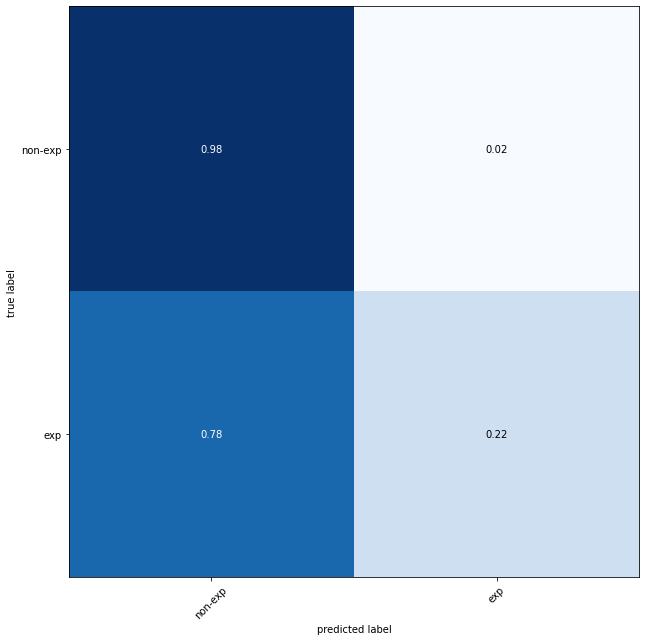

In [26]:
xgbc = XGBClassifier(objective="binary:logistic", random_state=42, eval_metric='logloss')
print(xgbc)
xgb = xgbc.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))

print(roc_auc_score(y_test, y_pred))
create_cm(y_test, y_pred)

In [58]:
y_prob = xgb.predict_proba(X_test)[:,1]

array([0.00954473, 0.3880736 , 0.01177181, 0.03482464, 0.13662535,
       0.893909  , 0.97110623, 0.03963117, 0.06360947, 0.03199798,
       0.04092723, 0.6728348 , 0.01163099, 0.01292389, 0.01412985,
       0.3277652 , 0.01371998, 0.03080985, 0.0262366 , 0.05771911,
       0.00948041, 0.02495359, 0.02165428, 0.00541735, 0.01476044,
       0.02528451, 0.01594062, 0.02163827, 0.01357426, 0.02651217,
       0.5898649 , 0.0094854 , 0.9934202 , 0.01024816, 0.01765969,
       0.00787254, 0.01047579, 0.01676207, 0.00453304, 0.02546428,
       0.00285939, 0.04541079, 0.01157744, 0.0128839 , 0.94620013,
       0.97801125, 0.01341652, 0.00534007, 0.01241342, 0.02426624,
       0.01605353, 0.03428581, 0.03217267, 0.03934462, 0.97327924,
       0.01647423, 0.02556415, 0.01127883, 0.02858085, 0.12269744,
       0.17294046, 0.08045714, 0.05853193, 0.03578334, 0.0083768 ,
       0.00439036, 0.03413223, 0.06692765, 0.02240027, 0.01865683,
       0.02575958, 0.07163801, 0.01778948, 0.05809084, 0.00525

In [56]:
# # Predict on whole heuristics set
# X = cv.transform(df['clean_text'])
# y = df['labels']

# df['pred_labels_xgb'] = pd.Series(xgb.predict(X))

# df[['text', 'pred_labels_xgb']].to_csv('distant_predicted_labels_xgb', sep='\t')

In [57]:
# mijn_connection = dplyr::filter(fb_subjective, grepl(".mijn vader.|.mijn moeder.|.mijn ouders.|.mijn schoonvader.|.mijn schoonmoeder.|.mijn

# kind|.mijn man.|.mijn vrouw.|.mijn zoon|.mijn dochter|.mijn broer|.mijn zus|.mijn opa.|.mijn oma.|.mijn neef|.mijn nicht|.mijn tante|.mijn oom", fb_subjective$message , ignore.case = TRUE))

 

# Some other patterns which I still want to look into:

# ...heb ... gehad / ..ben ... geweest / ik als... / ik was / was ik
#  mijn + familie/gezin/vriend*/collega*/…
# Mijn + lichaam / immunsystem / arts / omgeving; bij mij (more words related to one’s own individual experiences?)
 

# To look for words which appear near each other, so, which occur within a certain “distance” from each other I use:

 

# pattern = dplyr::filter(fb_subjective, grepl("heb\\W+(?:\\w+\\W+){1,6}?gehad", fb_subjective$message , ignore.case = TRUE))